# Virtual screening workflow using de-novo design 

This notebook will describe a virtual screening workflow using NVIDIA's MOLMIM as de-novo molecule generator. The goal of  this virtual screening workflow is to find out putative inhibitors of EGFR. I have used several open source toolkits like RdKit, Datamol, Mols2grid, prolif, Molscore, NglView, Umap and popular open sourced Python data analysis libraries (e.g. Pandas, Numpy, Matplotlib etc) to built this pipeline. 

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import pprint

import datamol as dm
import mols2grid
import prolif as plf
from rdkit import Chem, DataStructs, RDConfig
from rdkit.Chem import Draw, PandasTools, Descriptors, DataStructs
from rdkit.Chem.Descriptors import qed
import medchem as mc
from moleval.metrics.metrics import GetMetrics
import nglview

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

from utils import CreateProlifFingerPrint, create_umap_df

## Seed molecules

35 small molecules for target EGFR were obtained from ChEMBL. These molecules are either FDA approved molecules or molecules in clinical trials (phase 2 and 3).These molecules are going to be used as seeds for de novo generation of new molecules.

In [2]:
mols2grid.display("data/egfr_chembl.sdf", size=(300, 300))

MolGridWidget()

In [3]:
chembl_df = PandasTools.LoadSDF("data/egfr_chembl.sdf")

In [4]:
chembl_df["smiles"] = chembl_df["ROMol"].apply(lambda x: Chem.MolToSmiles(x))
chembl_df["generation"] = "seeds"

In [5]:
list_of_seed_molecules = chembl_df.smiles.to_list()

## De novo molecule generation

### Molecules generation

Molmim by Nvidia is used in this workflow to generate new molecules using the seeds. Molmim follows a variational autoencoder based approach. Molmim is available via the Bionemo platform. In the enterprise version, first time user gets 1000 free API tokens. But users can use the web service and generates molecules. 
15 molecules were generated for each seeds with minimum 0.7 tanimoto similarity and QED was used to optimize the property. Total 399 unique molecules were generated.


In [6]:
molmim_df = PandasTools.LoadSDF("data/first_gen/processed.sdf")

In [7]:
molmim_df["smiles"] = molmim_df["ROMol"].apply(lambda x: Chem.MolToSmiles(x))

In [8]:
molmim_df.shape

(399, 3)

In [9]:
list_of_molmim_smiles = molmim_df.smiles.to_list()
target_smiles = list_of_seed_molecules


### Metrics

Initials metrics were generated using Moleval functionlaity of Molscore package.

In [10]:
MetricEngine = GetMetrics(
    n_jobs=1,
    device='cpu',
    batch_size=512,
)
metrics = MetricEngine.calculate(
    list_of_molmim_smiles,
    calc_valid=True,
    calc_unique=True,
    unique_k=10000,
    se_k=1000,
    sp_k=1000,
    properties=True,
)

Cleaning up reference smiles


c:\Users\abhik\miniconda3\envs\new-env-name\lib\site-packages\moleval\metrics\metrics.py:205: UserWarning: Less than 1000 molecules so SEDiv is non-standard.
  warnings.warn(f'Less than {se_k} molecules so SEDiv is non-standard.')
c:\Users\abhik\miniconda3\envs\new-env-name\lib\site-packages\moleval\metrics\metrics.py:211: UserWarning: Less than 1000 molecules so SPDiv is non-standard.
  warnings.warn(f'Less than {sp_k} molecules so SPDiv is non-standard.')


In [11]:
pprint.pprint(metrics)

{'#': 399,
 '# scaffolds': 303,
 '# valid': 399,
 '# valid & unique': 399,
 'FG': 0.04714959279897128,
 'Filters': 0.681704260651629,
 'IntDiv1': 0.8278673972443484,
 'IntDiv2': 0.8107300377279317,
 'Purchasable_ZINC20': 0.005012531328320802,
 'RS': 0.09210526315789473,
 'SEDiv': 0.3107769423558897,
 'SPDiv': 0.8957775814832775,
 'ScaffDiv': 0.8014808411673983,
 'ScaffUniqueness': 0.7593984962406015,
 'Uniqueness': 1.0,
 'Validity': 1.0}


### Quality of the generated molecules

In [12]:
molmim_df["molwt"] = molmim_df["ROMol"].apply(lambda x: Descriptors.ExactMolWt(x))
molmim_df["qed"] = molmim_df["ROMol"].apply(lambda x: Descriptors.qed(x))
molmim_df["sascore"] = molmim_df["ROMol"].apply(lambda mol: sascorer.calculateScore(mol))

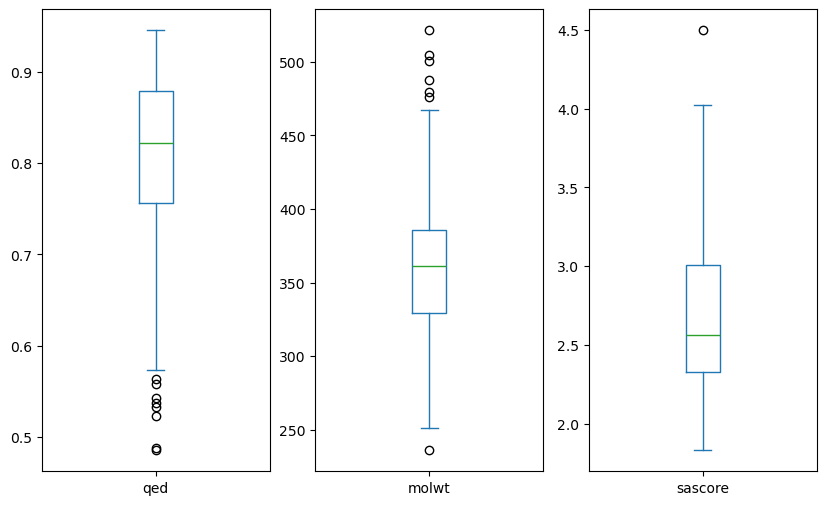

In [13]:
molmim_df[["qed", "molwt", "sascore"]].plot(kind= "box", subplots=True, sharey=False, figsize=(10, 6))

plt.show()

### UMAP visualisation

In [14]:
molmim_df["generation"] = "gen_1"

In [15]:
concat_df_1 = pd.concat([molmim_df, chembl_df])

In [16]:
smiles_list_1 = concat_df_1.smiles.to_list()
generation_list_1 = concat_df_1.generation.to_list()

In [17]:
umap_df_1 = create_umap_df(smiles_list=smiles_list_1, generation_list=generation_list_1)

c:\Users\abhik\miniconda3\envs\new-env-name\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [18]:
umap_df_1.head()

,UMAP1,UMAP2,Source
0,11.519844,5.558708,gen_1
1,11.250462,5.406710,gen_1
2,11.396249,5.267474,gen_1
3,11.262063,5.474868,gen_1
4,11.507819,5.567914,gen_1


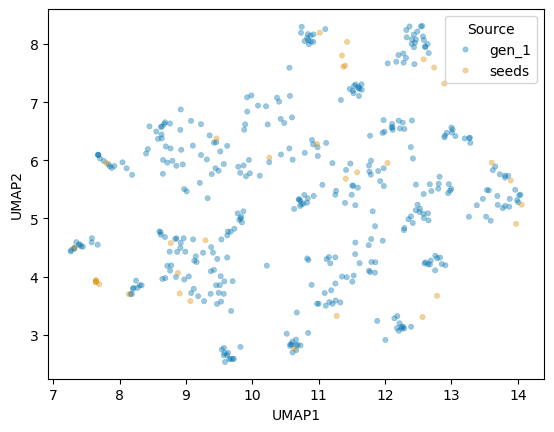

In [19]:
sns.scatterplot(
        data=umap_df_1,
        x="UMAP1",
        y="UMAP2",
        hue="Source",
        edgecolor=None,
        s=15,
        alpha=0.4,
        palette="colorblind"
        
    )
plt.show()

## Removal of structural alerts and reactive molecules

Structral alerts were done using Medchem filters from datamol.

### Structural alerts filter

In [20]:
mc.structural.CommonAlertsFilters.list_default_available_alerts()


,rule_set_name,smarts,catalog_description,rule_set,source
0,Glaxo,55,Glaxo Wellcome Hard filters,1,ChEMBL
1,Dundee,105,University of Dundee NTD Screening Library Fil...,2,ChEMBL
2,BMS,180,Bristol-Myers Squibb HTS Deck filters,3,ChEMBL
3,PAINS,481,PAINS filters,4,ChEMBL
4,SureChEMBL,166,SureChEMBL Non-MedChem Friendly SMARTS,5,ChEMBL
5,MLSMR,116,NIH MLSMR Excluded Functionality filters (MLSMR),6,ChEMBL
6,Inpharmatica,91,Unwanted fragments derived by Inpharmatica Ltd.,7,ChEMBL
7,LINT,57,Pfizer lint filters (lint),8,ChEMBL
8,Alarm-NMR,75,Reactive False Positives in Biochemical Screen...,9,Litterature
9,AlphaScreen-Hitters,6,Structural filters for compounds that may be a...,10,Litterature


I have used PAINS filter to identify the frequent hitters and "Reactive-Unstable-toxic" filters to identify unwanted motifs in the generate molecules.

In [21]:
alerts = mc.structural.CommonAlertsFilters()
                            

In [22]:
alerts = mc.structural.CommonAlertsFilters(alerts_set=["PAINS", "Reactive-Unstable-Toxic"])

In [23]:
molmim_df = alerts(
        mols=molmim_df["ROMol"].tolist(),
        n_jobs=-1,
        progress=True,
        progress_leave=True,
        scheduler="auto",
)
molmim_df.head()

Common alerts filtering:   0%|          | 0/399 [00:00<?, ?it/s]

,mol,pass_filter,status,reasons
0,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,True,ok,None
1,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,True,ok,None
2,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,True,ok,None
3,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,True,ok,None
4,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,True,ok,None


In [24]:
molmim_df["pass_filter"].value_counts()

pass_filter
True     210
False    189
Name: count, dtype: int64

In [25]:
fail_df = molmim_df.query("pass_filter == False")
fail_df.tail(20)

,mol,pass_filter,status,reasons
370,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,False,exclude,"Acrylamides;Michael acceptors (α,β-unsaturated..."
371,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,False,exclude,"Acrylamides;Michael acceptors (α,β-unsaturated..."
372,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,False,exclude,"Acrylamides;Michael acceptors (α,β-unsaturated..."
373,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,False,exclude,"Acrylamides;Michael acceptors (α,β-unsaturated..."
374,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,False,exclude,"Acrylamides;Michael acceptors (α,β-unsaturated..."
375,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,False,exclude,"Acrylamides;Michael acceptors (α,β-unsaturated..."
376,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,False,exclude,"Acrylamides;Michael acceptors (α,β-unsaturated..."
379,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,False,exclude,"N,N-Dialkyl aniline derivatives (2);Simple ani..."
381,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,False,exclude,Activated halides (α-halogen substituted N-het...
382,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,False,exclude,Simple anilines and phenols


In [26]:
pprint.pprint(fail_df.reasons.value_counts())

reasons
N,N-Dialkyl aniline derivatives (2);Simple anilines and phenols                                                                                                                                                       31
Simple anilines and phenols                                                                                                                                                                                           23
Alkyl Halides                                                                                                                                                                                                         17
Acrylamides;Michael acceptors (α,β-unsaturated carbonyls);Activated double bonds (2)                                                                                                                                  13
Acrylamides;Michael acceptors (α,β-unsaturated carbonyls);Alkyl Halides                                                     

In [68]:
mols2grid.display(fail_df, mol_col= "mol", size=(300, 300))

MolGridWidget()

In [28]:
molmim_processed = molmim_df.query("pass_filter == True")

In [29]:
molmim_processed.shape

(210, 4)

### Drug likeness filters

I also decided to keep the molecules that satisfies to Lipnisk's rule of 5. 

In [30]:
molmim_processed["MolWt"] = molmim_processed["mol"].apply(Descriptors.ExactMolWt)
molmim_processed["LogP"] = molmim_processed["mol"].apply(Descriptors.MolLogP)
molmim_processed["NumHDonors"] = molmim_processed["mol"].apply(Descriptors.NumHDonors)
molmim_processed["NumHAcceptors"] = molmim_processed["mol"].apply(Descriptors.NumHAcceptors)

C:\Users\abhik\AppData\Local\Temp\ipykernel_19476\2579213675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molmim_processed["MolWt"] = molmim_processed["mol"].apply(Descriptors.ExactMolWt)
C:\Users\abhik\AppData\Local\Temp\ipykernel_19476\2579213675.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  molmim_processed["LogP"] = molmim_processed["mol"].apply(Descriptors.MolLogP)
C:\Users\abhik\AppData\Local\Temp\ipykernel_19476\2579213675.py:3: SettingWithCopyWarning: 
A value is trying to be set on a c

In [31]:
molmim_processed = molmim_processed.query("MolWt >= 160 & MolWt <= 500 & LogP <= 5 &  NumHDonors <= 5 & NumHAcceptors <= 10")

In [32]:
molmim_processed.head()

,mol,pass_filter,status,reasons,MolWt,LogP,NumHDonors,NumHAcceptors
0,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,True,ok,None,308.084017,2.8493,1,5
1,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,True,ok,None,321.115651,2.7645,1,5
2,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,True,ok,None,349.110566,2.6812,1,5
3,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,True,ok,None,349.110566,2.4003,1,5
4,<rdkit.Chem.rdchem.Mol object at 0x0000020D27E...,True,ok,None,351.126216,2.7731,1,6


In [33]:
PandasTools.WriteSDF(molmim_processed, "data/processed_molmim_ligands.sdf", molColName="mol", properties=list(molmim_processed.columns) )

208 molecules will be prepared for docking the next step.

# Docking

Next the filtered molecules were dockind using SMINA. I used crsytal structure of wild type EGFR with Osimeritinib as the target structure and ligand Osimeritinib YY3 as reference. The docking protocol was validated by redocking Osimeritinib in the crystal structure. PDB entry 4zau was used as target structure.

In [34]:
!obabel "data/4zau_clean.pdb" -O "data/4zau_processed.pdb" -p

*** Open Babel Warning  in OpenBabel::OBMol::PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders (title is data/4zau_clean.pdb)

1 molecule converted


In [35]:
!obabel "data/4zau_yy3.sdf" -O "data/yy3_processed.sdf" -p

1 molecule converted


In [36]:
!smina -r "data/4zau_processed.pdb" -l "data/yy3_processed.sdf" --autobox_ligand "data/4zau_yy3.sdf" --num_modes 1 -o "data/redocked_yy3.sdf"

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 503899264

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1

In [37]:
view = nglview.show_structure_file("data/pdb4zau.ent")
view.add_component("data/redocked_yy3.sdf")
view

NGLWidget()

Next filtered output of Molmim were docked in 2ITO using IRE as reference.

In [38]:
!obabel "data/processed_molmim_ligands.sdf" -O "data/processed_molmim_ligands_obabel.sdf" -p

208 molecules converted


In [39]:
!smina -r "data/4zau_processed.pdb" -l "data/processed_molmim_ligands_obabel.sdf" --autobox_ligand "data/4zau_yy3.sdf" --num_modes 1 -o "data/4zau_docked_molmim_ligands_final.sdf" 

   _______  _______ _________ _        _______ 
  (  ____ \(       )\__   __/( (    /|(  ___  )
  | (    \/| () () |   ) (   |  \  ( || (   ) |
  | (_____ | || || |   | |   |   \ | || (___) |
  (_____  )| |(_)| |   | |   | (\ \) ||  ___  |
        ) || |   | |   | |   | | \   || (   ) |
  /\____) || )   ( |___) (___| )  \  || )   ( |
  \_______)|/     \|\_______/|/    )_)|/     \|


smina is based off AutoDock Vina. Please cite appropriately.

Weights      Terms
-0.035579    gauss(o=0,_w=0.5,_c=8)
-0.005156    gauss(o=3,_w=2,_c=8)
0.840245     repulsion(o=0,_c=8)
-0.035069    hydrophobic(g=0.5,_b=1.5,_c=8)
-0.587439    non_dir_h_bond(g=-0.7,_b=0,_c=8)
1.923        num_tors_div

Using random seed: 744646944

0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************

mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
1

In [40]:
!obabel "data/4zau_docked_molmim_ligands.sdf" -O "data/4zau_docked_molmim_ligands.sdf" -p

208 molecules converted


# Protein ligand fingerprint generation and filtering of docking poses

These docked ligands were further rescored using protein ligand interaction fingerprint. Prolif library has been used for this purpose. Osimeritinib bound wild structure of EGFR 4gau was used as reference.

In [41]:
fp_generator = CreateProlifFingerPrint(receptor_file="data/4zau_processed.pdb")

In [42]:
ref_fp = fp_generator.create_fingerprint_of_reference_ligand(sdf_file = "data/4zau_yy3.sdf", index = 0)

  0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
ref_fp

<prolif.fingerprint.Fingerprint: 9 interactions: ['Hydrophobic', 'HBAcceptor', 'HBDonor', 'Cationic', 'Anionic', 'CationPi', 'PiCation', 'PiStacking', 'VdWContact'] at 0x20d38a9eee0>

In [44]:
ref_df = ref_fp.to_dataframe(index_col="Pose")
ref_df.rename(index={0: -1}, inplace=True)
# set the ligand name to be the same as poses
ref_df.rename(columns={"reference": ref_df.columns.levels[0][0]}, inplace=True)

In [45]:
poses_fp = fp_generator.create_fingerprints_of_docking_poses(sdf_file="data/4zau_docked_molmim_ligands.sdf")

  0%|          | 0/208 [00:00<?, ?it/s]

In [46]:
poses_df = poses_fp.to_dataframe(index_col=False)

In [47]:
df_ref_poses = (
    pd.concat([ref_df, poses_df])
    .fillna(False)
    .sort_index(
        axis=1,
        level=1,
        key=lambda index: [plf.ResidueId.from_string(x) for x in index],
    )
)

In [48]:
df_ref_poses.shape

(209, 78)

In [49]:
bitvectors = plf.to_bitvectors(df_ref_poses)
tanimoto_sims = DataStructs.BulkTanimotoSimilarity(bitvectors[0], bitvectors[1:])

In [50]:
result_df = PandasTools.LoadSDF("data/4zau_docked_molmim_ligands.sdf")

In [51]:
result_df["plif_sim"] = tanimoto_sims

In [52]:
result_df["smiles"] = result_df["ROMol"].apply(lambda mol: Chem.MolToSmiles(mol))

In [53]:
result_df["qed"] = result_df["ROMol"].apply(lambda x: Descriptors.qed(x))
result_df["num_heavy_atoms"] = result_df["ROMol"].apply(lambda x: Chem.rdMolDescriptors.CalcNumHeavyAtoms(x))
result_df["LE"] = -(result_df["minimizedAffinity"].astype(float))/result_df["num_heavy_atoms"].astype(float)
result_df["sascore"] = result_df["ROMol"].apply(lambda mol: sascorer.calculateScore(mol))
result_df = result_df.astype({"minimizedAffinity": float})



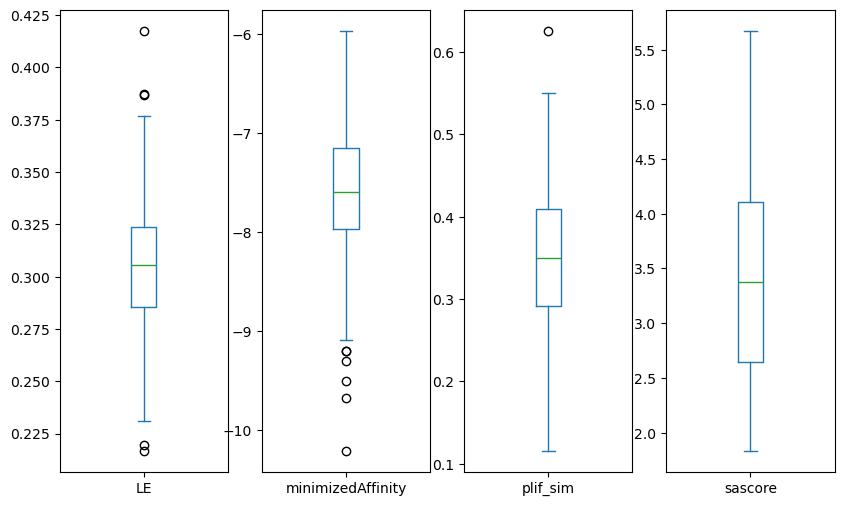

In [54]:
result_df[["LE", "minimizedAffinity", "plif_sim", "sascore"]].plot(kind= "box", subplots=True, sharey=False, figsize=(10, 6))

plt.show()

In [55]:
result_df.head()

,minimizedAffinity,ID,ROMol,plif_sim,smiles,qed,num_heavy_atoms,LE,sascore
0,-7.28466,,<rdkit.Chem.rdchem.Mol object at 0x0000020D38C...,0.444444,Fc1c(Cl)cccc1Nc1cc(N2CCOCC2)ncn1,0.944643,21,0.346889,2.278025
1,-7.59439,,<rdkit.Chem.rdchem.Mol object at 0x0000020D38C...,0.400000,C[NH+]1CCN(c2cc(Nc3cccc(Cl)c3F)ncn2)CC1,0.895209,22,0.345200,3.454704
2,-7.70267,,<rdkit.Chem.rdchem.Mol object at 0x0000020D38C...,0.400000,CC(=O)N1CCN(c2cc(Nc3cccc(Cl)c3F)ncn2)CC1,0.922748,24,0.320945,2.289734
3,-7.39928,,<rdkit.Chem.rdchem.Mol object at 0x0000020D38C...,0.250000,C[NH+]1CCN(C(=O)c2nccnc2Nc2cccc(Cl)c2F)CC1,0.866109,24,0.308303,3.442760
4,-7.37289,,<rdkit.Chem.rdchem.Mol object at 0x0000020D38C...,0.380952,COc1c(Nc2cccc(Cl)c2F)ncnc1N1CC[NH+](C)CC1,0.869834,24,0.307204,3.499884


### Filtering the docking poses

In [56]:
result_df_filtered = result_df.query("minimizedAffinity < -0.7 & plif_sim > 0.4 & qed > 0.8")

In [57]:
result_df_filtered.shape

(32, 9)

In [58]:
mols2grid.display(result_df_filtered, smiles_col="smiles", size = (300, 300))

MolGridWidget()

![image](data/top_hit2_4zau.png)

![image](data/top_hit_4zau.png)

Visualisation of chemical space of Hits and all generated molecules

In [59]:
PandasTools.WriteSDF(result_df_filtered, "data/4zau_top_hits.sdf")

In [60]:
result_df["generation"] = "gen_1"
result_df["smiles"] = result_df["ROMol"].apply(lambda x: Chem.MolToSmiles(x))
result_df_smiles_list = result_df.smiles.to_list()

In [61]:
result_df_filtered["smiles"] = result_df_filtered["ROMol"].apply(lambda x: Chem.MolToSmiles(x))
result_df_filtered["generation"] = "Hits"

C:\Users\abhik\AppData\Local\Temp\ipykernel_19476\2375055299.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_filtered["smiles"] = result_df_filtered["ROMol"].apply(lambda x: Chem.MolToSmiles(x))
C:\Users\abhik\AppData\Local\Temp\ipykernel_19476\2375055299.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_df_filtered["generation"] = "Hits"


In [62]:
hits_concat_df = pd.concat([result_df_filtered, chembl_df, result_df])

In [63]:
hits_concat_df_smiles_list = hits_concat_df.smiles.to_list()
hits_concat_df_generation_list = hits_concat_df.generation.to_list()

In [64]:
all_umap_df = create_umap_df(smiles_list=hits_concat_df_smiles_list, generation_list=hits_concat_df_generation_list)

c:\Users\abhik\miniconda3\envs\new-env-name\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


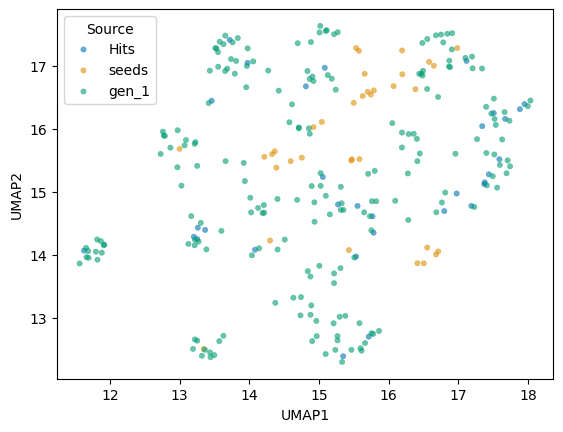

In [65]:
sns.scatterplot(
        data=all_umap_df,
        x="UMAP1",
        y="UMAP2",
        hue="Source",
        edgecolor=None,
        s=15,
        alpha=0.6,
        palette ="colorblind"
        
    )
plt.show()

## Summary

![image](data/workflow_2.png)

- Reproducible workflow to generate new ideas using protein ligand interaction information
- Modular workflow. Molecules from any process can be used (Vitual library)
- With better set of designed molecules, can generate useful ideas
- Better docking program like GOLD or GLIDE will produce better result
